In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('hw05_data.csv')
df

,Weather,Just Ate,Work Late,Will Exercise?
0,Sunny,yes,no,yes
1,Rainy,yes,yes,no
2,Sunny,no,yes,yes
3,Rainy,no,no,no
4,Rainy,no,no,yes
5,Sunny,yes,no,yes
6,Rainy,no,yes,no


In [4]:
df.dtypes

Weather           object
Just Ate          object
Work Late         object
Will Exercise?    object
dtype: object

In [5]:
# convert the columns to categorical

df['Weather'] = df['Weather'].astype('category')
df['Just Ate'] = df['Just Ate'].astype('category')
df['Work Late'] = df['Work Late'].astype('category')
df['Will Exercise?'] = df['Will Exercise?'].astype('category')

df.dtypes

Weather           category
Just Ate          category
Work Late         category
Will Exercise?    category
dtype: object

In [6]:
df['Will Exercise?'].value_counts()

yes    4
no     3
Name: Will Exercise?, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Will Exercise?'] = le.fit_transform(df['Will Exercise?'])
df['Will Exercise?'].value_counts()

1    4
0    3
Name: Will Exercise?, dtype: int64

In [8]:
# one hot encoding the data using get_dummies
df = pd.get_dummies(df, columns=['Weather', 'Just Ate', 'Work Late'])
df

,Will Exercise?,Weather_Rainy,Weather_Sunny,Just Ate_no,Just Ate_yes,Work Late_no,Work Late_yes
0,1,0,1,0,1,1,0
1,0,1,0,0,1,0,1
2,1,0,1,1,0,0,1
3,0,1,0,1,0,1,0
4,1,1,0,1,0,1,0
5,1,0,1,0,1,1,0
6,0,1,0,1,0,0,1


In [9]:
X_train_categorical = df.select_dtypes(exclude=["int64", "float64"]).copy()
X_train_categorical

,Weather_Rainy,Weather_Sunny,Just Ate_no,Just Ate_yes,Work Late_no,Work Late_yes
0,0,1,0,1,1,0
1,1,0,0,1,0,1
2,0,1,1,0,0,1
3,1,0,1,0,1,0
4,1,0,1,0,1,0
5,0,1,0,1,1,0
6,1,0,1,0,0,1


In [10]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_categorical)

X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_categorical),
    # index is important to ensure we can concatenate with other columns
    index=X_train_categorical.index,
    # we are dummying multiple columns at once, so stack the names
    columns=np.hstack(ohe.categories_)
)

X_train_ohe

,0,1,0,1,0,1,0,1,0,1,0,1
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
5,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
6,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


### Modelling

In [11]:
# split the data into X and y

X = df.drop('Will Exercise?', axis=1)
y = df['Will Exercise?']

In [12]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='gini',)
dtree.fit(X, y)


DecisionTreeClassifier()

In [13]:
dtree.score(X, y)

0.8571428571428571

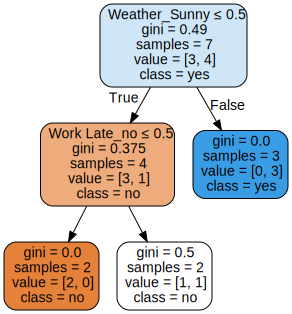

In [14]:
# display the decision tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(dtree, out_file=None, feature_names=X.columns, class_names=['no', 'yes'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [15]:
# print true if the user will exercise, false otherwise

print("Display True if the Person will Exercise and False if not given the following condition: Its sunny , Just Ate : yes , Work Late : yes :",dtree.predict([[0, 1, 0, 1, 0, 1]]) == 1)

Display True if the Person will Exercise and False if not given the following condition: Its sunny , Just Ate : yes , Work Late : yes : [ True]


#### The formula for entropy is given by: $H(X) = -\sum_{i=1}^{n}p(x_i)log_2(p(x_i))$ where $p(x_i)$ is the probability of the event $x_i$.

In [29]:
# calculate the entropy of a dataset
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

entropy(df['Will Exercise?'])

0.9852281360342515

#### The formula for information gain is given by: $IG(D,A) = H(D) - \sum_{i=1}^{n}\frac{|D_i|}{|D|}H(D_i)$ where $D$ is the dataset, $A$ is the attribute, $D_i$ is the subset of $D$ where $A = a_i$ and $H(D)$ is the entropy of $D$.

In [26]:
# calculate the information gain
def InfoGain(data, split_attribute_name, target_name="Will Exercise?"):
    # calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
    
    # calculate the values and the corresponding counts for the split attribute 
    vals, counts= np.unique(data[split_attribute_name], return_counts=True)
    
    # calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
    
    # calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

InfoGain(df, 'Will Exercise?')

0.9852281360342515

In [28]:
# find the best feature to split on
def find_best_feature(data, features, target):
    # calculate the information gain for the data and each feature
    information_gains = [InfoGain(data, feature, target) for feature in features]
    # return the feature with the highest information gain
    return features[np.argmax(information_gains)]

best = find_best_feature(df, X.columns, 'Will Exercise?')
print("Best feature to split on is:", best)

Best feature to split on is: Weather_Rainy


In [24]:
# final decision tree
def DecisionTree(data, features, target, level=0):
    # if all the target values are the same, return the target
    if len(data[target].unique()) == 1:
        return data[target].unique()[0]
    
    # if there are no more features to split on, return the majority class
    if len(features) == 0:
        return data[target].value_counts().idxmax()
    
    # find the feature that best splits the data
    best_feature = find_best_feature(data, features, target)
    
    # create a tree node
    tree = {best_feature:{}}
    
    # remove the feature with the best split from the feature space
    features = [i for i in features if i != best_feature]
    
    # grow a branch under the root node for each possible value of the root node feature
    for value in data[best_feature].unique():
        value = value
        # split the dataset
        sub_data = data.where(data[best_feature] == value).dropna()
        
        # call the algorithm recursively
        subtree = DecisionTree(sub_data, features, target, level+1)
        
        # add the sub tree, grown from the sub dataset to the tree under the root node
        tree[best_feature][value] = subtree
        
        
    return tree

# print the decision tree
DecisionTree(df, X.columns, 'Will Exercise?')

{'Weather_Rainy': {0: 1.0,
  1: {'Work Late_no': {0.0: 0.0,
    1.0: {'Weather_Sunny': {0.0: {'Just Ate_no': {1.0: {'Just Ate_yes': {0.0: {'Work Late_yes': {0.0: 0.0}}}}}}}}}}}}